In [1]:
import os
import logging
import torch
import subprocess
import pandas as pd
from typing import Optional
from pathlib import Path
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu
import bert_score
import textstat

from transformers import PegasusTokenizer, PegasusForConditionalGeneration, TFPegasusForConditionalGeneration
from langchain.text_splitter import RecursiveCharacterTextSplitter
from tqdm import tqdm

/workspace/persistent/ragsum/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.basicConfig(level=logging.INFO, force=True)

In [3]:
if torch.cuda.is_available():
    logging.info(f'GPU Name: {torch.cuda.get_device_name(0)}')
    logging.info(f'CUDA Version: {torch.version.cuda}')
    logging.info(f'GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB')
    logging.info(f'GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB')

    try:
        logging.info('\nDetailed GPU Info:\n')
        subprocess.run(['nvidia-smi'], check=True)
    except FileNotFoundError:
        logging.info('nvidia-smi not found. Ensure NVIDIA drivers are installed.')
else:
    logging.info('No GPU detected. Running on CPU.')

INFO:root:GPU Name: NVIDIA H100 PCIe
INFO:root:CUDA Version: 12.4
INFO:root:GPU Memory Allocated: 0.00 GB
INFO:root:GPU Memory Reserved: 0.00 GB
INFO:root:
Detailed GPU Info:



Mon Mar 10 13:27:19 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               On  | 00000000:21:00.0 Off |                    0 |
| N/A   39C    P0             223W / 310W |      6MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
def load_if_scraped(company_id: str) -> Optional[pd.DataFrame]:
    file_path = Path('..') / 'data' / f'{company_id}.csv'
    if file_path.exists():
        df = pd.read_csv(
            file_path,
            sep='\t',
            quoting=1,
            escapechar='\\',
            doublequote=True,
            quotechar='"',
        )
        logging.info('successfully loaded local transcripts')
        return df
    else:
        logging.debug('no local transcripts found')
    return None

In [8]:
df = load_if_scraped('26446')

df

INFO:root:successfully loaded local transcripts


,companyid,companyname,mostimportantdateutc,mostimportanttimeutc,headline,full_text,uuid,word_count,word_count_nltk
0,26446,"Chipotle Mexican Grill, Inc.",2023-02-07,21:30:00,"Chipotle Mexican Grill, Inc., Q4 2022 Earnings...",Operator: Good day and welcome to the Chipotle...,29dc3fab-6665-4ea6-88ea-30357ab3d9c7,19869,23001
1,26446,"Chipotle Mexican Grill, Inc.",2023-04-25,20:30:00,"Chipotle Mexican Grill, Inc., Q1 2023 Earnings...",Operator: Hello and welcome to the Chipotle Me...,29dc3fab-6665-4ea6-88ea-30357ab3d9c7,20835,24017
2,26446,"Chipotle Mexican Grill, Inc.",2023-07-26,20:30:00,"Chipotle Mexican Grill, Inc., Q2 2023 Earnings...","Operator: Good afternoon, and welcome to the C...",29dc3fab-6665-4ea6-88ea-30357ab3d9c7,20528,23493
3,26446,"Chipotle Mexican Grill, Inc.",2023-10-26,20:30:00,"Chipotle Mexican Grill, Inc., Q3 2023 Earnings...","Operator: Good day, and welcome to the Chipotl...",29dc3fab-6665-4ea6-88ea-30357ab3d9c7,40253,46589
4,26446,"Chipotle Mexican Grill, Inc.",2024-02-06,21:30:00,"Chipotle Mexican Grill, Inc., Q4 2023 Earnings...",Operator: Good afternoon and welcome to the Ch...,29dc3fab-6665-4ea6-88ea-30357ab3d9c7,20725,24011
5,26446,"Chipotle Mexican Grill, Inc.",2024-04-24,20:30:00,"Chipotle Mexican Grill, Inc., Q1 2024 Earnings...",Operator: Good day and welcome to the Chipotle...,29dc3fab-6665-4ea6-88ea-30357ab3d9c7,29047,33537
6,26446,"Chipotle Mexican Grill, Inc.",2024-07-24,20:30:00,"Chipotle Mexican Grill, Inc., Q2 2024 Earnings...",Operator: Good afternoon and welcome to the Ch...,29dc3fab-6665-4ea6-88ea-30357ab3d9c7,20743,23821
7,26446,"Chipotle Mexican Grill, Inc.",2024-10-29,20:30:00,"Chipotle Mexican Grill, Inc., Q3 2024 Earnings...","Operator: Good day, and welcome to the Chipotl...",29dc3fab-6665-4ea6-88ea-30357ab3d9c7,19867,22653
8,26446,"Chipotle Mexican Grill, Inc.",2025-02-04,21:30:00,"Chipotle Mexican Grill, Inc., Q4 2024 Earnings...","Operator: Good day, and welcome to the Chipotl...",29dc3fab-6665-4ea6-88ea-30357ab3d9c7,30946,35107


In [10]:
model_name = 'human-centered-summarization/financial-summarization-pegasus'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at human-centered-summarization/financial-summarization-pegasus and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def summarize_text(text: str):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=512,
        chunk_overlap=50
    )
    
    chunks = text_splitter.split_text(text)
    summaries = []
    
    for chunk in tqdm(chunks):
        inputs = tokenizer(chunk, return_tensors='pt', truncation=True, max_length=512).to(device)
        summary_ids = model.generate(**inputs, max_length=150)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
    
    return summaries

def recursive_summary(text, target_length=512):
    summaries = summarize_text(text)
    combined_summary = ' '.join(summaries)
    
    while len(tokenizer.tokenize(combined_summary)) > target_length:
        summaries = summarize_text(combined_summary)
        combined_summary = ' '.join(summaries)

    return combined_summary

In [12]:
summaries = []
for text in tqdm(df.full_text):
    summary = recursive_summary(text=text)
    summaries.append(summary)

100%|██████████| 9/9 [24:24<00:00, 162.77s/it]


In [13]:
summaries[0]

"Q4 sales grow 11%, in-store sales grow 18% Nation Nation Nation Nation’s Board of Directors has declared a quarterly cash dividend of 15 cents per share. Q4 underlying sales rose 7% vs 6% in 3Q. Analysts ask about menu deactivations, M&A activity Taco Bell sees higher-income consumers coming more often. Q3: Are you seeing more frequency out of customers using your rewards program? Record number of new restaurants opened in fourth quarter Nation Nation Nation Nation’s Board of Directors declares quarterly dividend. savesay’s cost-cutting plan is bearing fruit. Record 100 new restaurants opened in fourth quarter ‘We’ve had a lot of supply chain challenges,’ says CEO. topological topological insulators. topological topological insulators. topological topological topological 3D topological topological topological topological topological topological topological topological 3D topological topological topological topological topological topological topological topological RemovalRemovalRemov

In [14]:
df['summaries'] = summaries

In [28]:
def evaluate_summary(row, model_name, type = 'baseline'):
    text_to_summarize = row.full_text
    summary = row.summaries
    uuid = row.uuid
    company_id = row.companyid
    company_name = row.companyname

    # 1. Compute ROUGE scores
    rouge_evaluator = Rouge()
    rouge_scores = rouge_evaluator.get_scores(summary, text_to_summarize)
    
    # If the evaluator returns a list (one element per summary), take the first element
    if isinstance(rouge_scores, list):
        rouge_scores = rouge_scores[0]
    
    # 2. Compute BLEU score (using simple tokenization)
    reference_tokens = text_to_summarize.split()
    candidate_tokens = summary.split()
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)
    
    # 3. Compute BERTScore (returns precision, recall, and F1)
    P, R, F1 = bert_score.score([summary], [text_to_summarize], lang='en')
    
    # 4. Calculate compression ratio (summary length divided by original length)
    original_len = len(text_to_summarize.split())
    summary_len = len(summary.split())
    compression_ratio = summary_len / original_len if original_len > 0 else 0
    
    readability = textstat.flesch_reading_ease(summary)
    
    results = {}
    results['model_name'] = model_name
    results['uuid'] = uuid
    results['companyid'] = company_id
    results['companyname'] = company_name

    for metric, scores in rouge_scores.items():
        results[f'{metric}_r'] = scores['r']
        results[f'{metric}_p'] = scores['p']
        results[f'{metric}_f'] = scores['f']
    
    results['bleu'] = bleu_score
    results['bert_precision'] = P.item()
    results['bert_recall'] = R.item()
    results['bert_f1'] = F1.item()
    results['compression_ratio'] = compression_ratio
    results['readability'] = readability
    
    return pd.DataFrame([results])

In [29]:
evaluation_results = pd.DataFrame()

for index, row in tqdm(df.iterrows()):
    evaluation_result = evaluate_summary(row, model_name)
    evaluation_results = pd.concat([evaluation_results, evaluation_result], ignore_index=True)

evaluation_results.head()

0it [00:00, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
1it [00:02,  2.58s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2it [00:05,  3.01s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
3it [00:07,  2.51s/it]Some weights of RobertaModel were not initialized from the

,model_name,uuid,companyid,companyname,rouge-1_r,rouge-1_p,rouge-1_f,rouge-2_r,rouge-2_p,rouge-2_f,rouge-l_r,rouge-l_p,rouge-l_f,bleu,bert_precision,bert_recall,bert_f1,compression_ratio,readability
0,human-centered-summarization/financial-summari...,29dc3fab-6665-4ea6-88ea-30357ab3d9c7,26446,"Chipotle Mexican Grill, Inc.",0.034237,0.631579,0.064953,0.004489,0.225352,0.008803,0.033761,0.622807,0.064051,6.620257e-49,0.751990,0.763812,0.757855,0.009110,-9.31
1,human-centered-summarization/financial-summari...,29dc3fab-6665-4ea6-88ea-30357ab3d9c7,26446,"Chipotle Mexican Grill, Inc.",0.017288,0.690909,0.033733,0.004068,0.442857,0.008061,0.017288,0.690909,0.033733,9.575181e-34,0.672548,0.751033,0.709627,0.013439,81.67
2,human-centered-summarization/financial-summari...,29dc3fab-6665-4ea6-88ea-30357ab3d9c7,26446,"Chipotle Mexican Grill, Inc.",0.026091,0.698795,0.050304,0.004248,0.307692,0.008380,0.026091,0.698795,0.050304,5.717829e-80,0.830567,0.771360,0.799869,0.005505,60.01
3,human-centered-summarization/financial-summari...,29dc3fab-6665-4ea6-88ea-30357ab3d9c7,26446,"Chipotle Mexican Grill, Inc.",0.052225,0.709877,0.097293,0.013280,0.417722,0.025741,0.050863,0.691358,0.094755,2.990537e-60,0.789958,0.759326,0.774339,0.007304,65.01
4,human-centered-summarization/financial-summari...,29dc3fab-6665-4ea6-88ea-30357ab3d9c7,26446,"Chipotle Mexican Grill, Inc.",0.034873,0.777778,0.066753,0.006946,0.406250,0.013659,0.034873,0.777778,0.066753,3.481206e-61,0.825145,0.777617,0.800676,0.007189,50.43


In [22]:
csv_filename = Path('..') / 'data' / 'evaluation_results.csv'

if os.path.exists(csv_filename):
    existing_df = pd.read_csv(csv_filename)
    if "model_name" in existing_df.columns and (existing_df["model_name"] == model_name).any():
        logging.info(f"model '{model_name}' already exists in {csv_filename}. no new row added.")
        updated_df = existing_df
    else:
        updated_df = pd.concat([existing_df, evaluation_results], ignore_index=True)
        logging.info(f"model '{model_name}' not found. appending new row to {csv_filename}.")
else:
    updated_df = evaluation_results
    logging.info(f"{csv_filename} not found. creating new file.")

updated_df.to_csv(csv_filename, index=False)
logging.info(f'results saved to {csv_filename}')

INFO:root:model 'human-centered-summarization/financial-summarization-pegasus' already exists in ../data/evaluation_results.csv. no new row added.


INFO:root:results saved to ../data/evaluation_results.csv


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

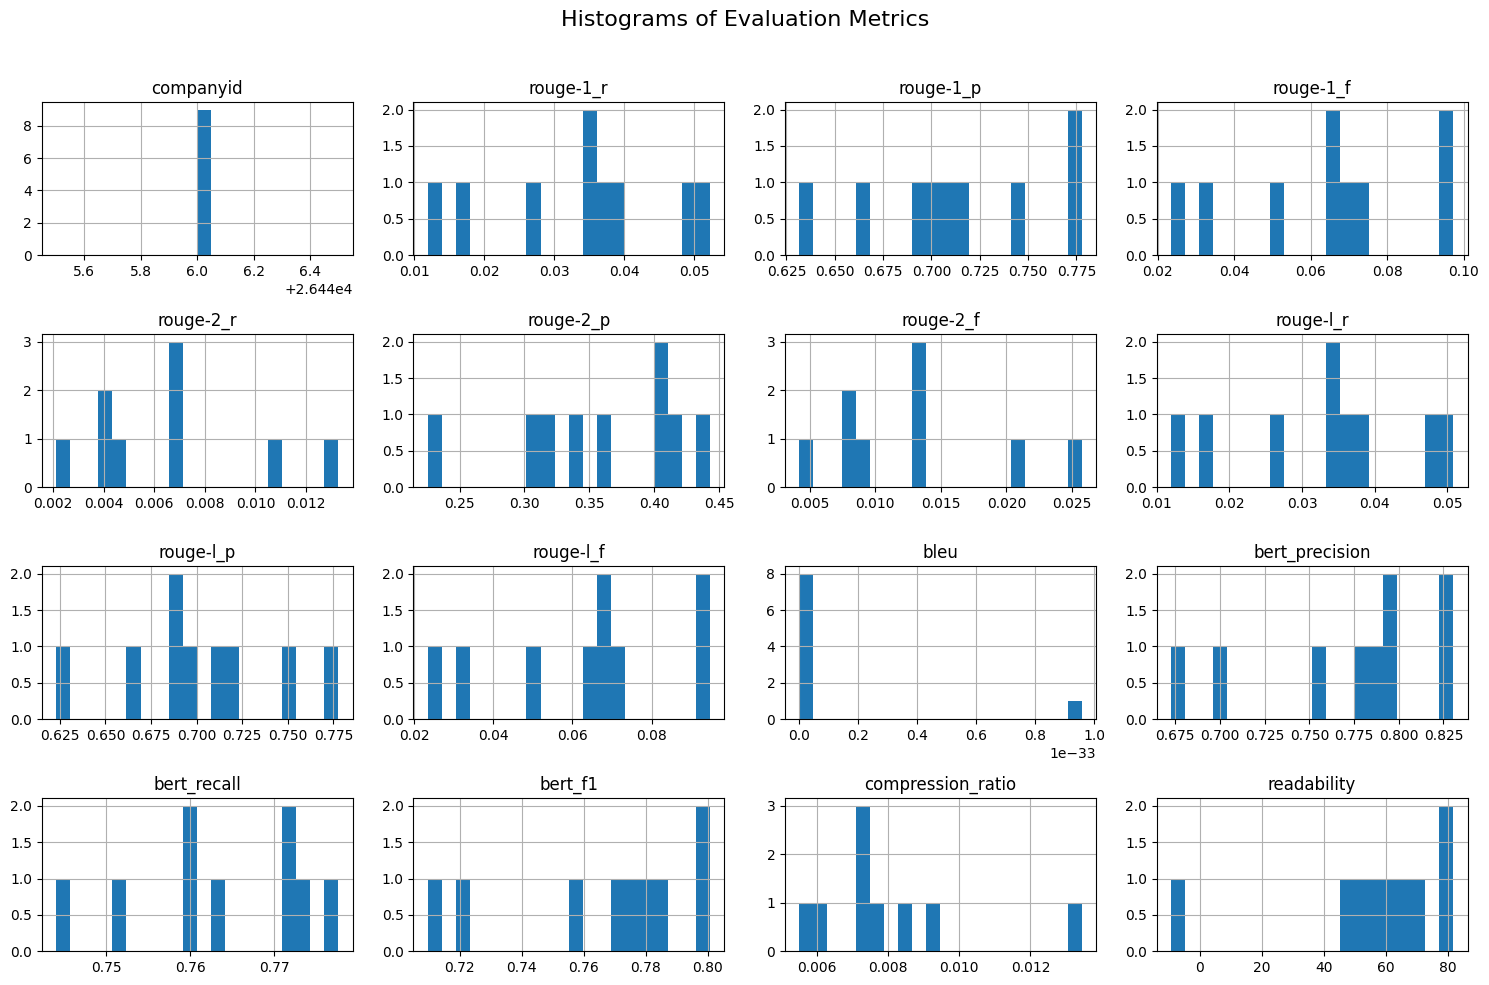

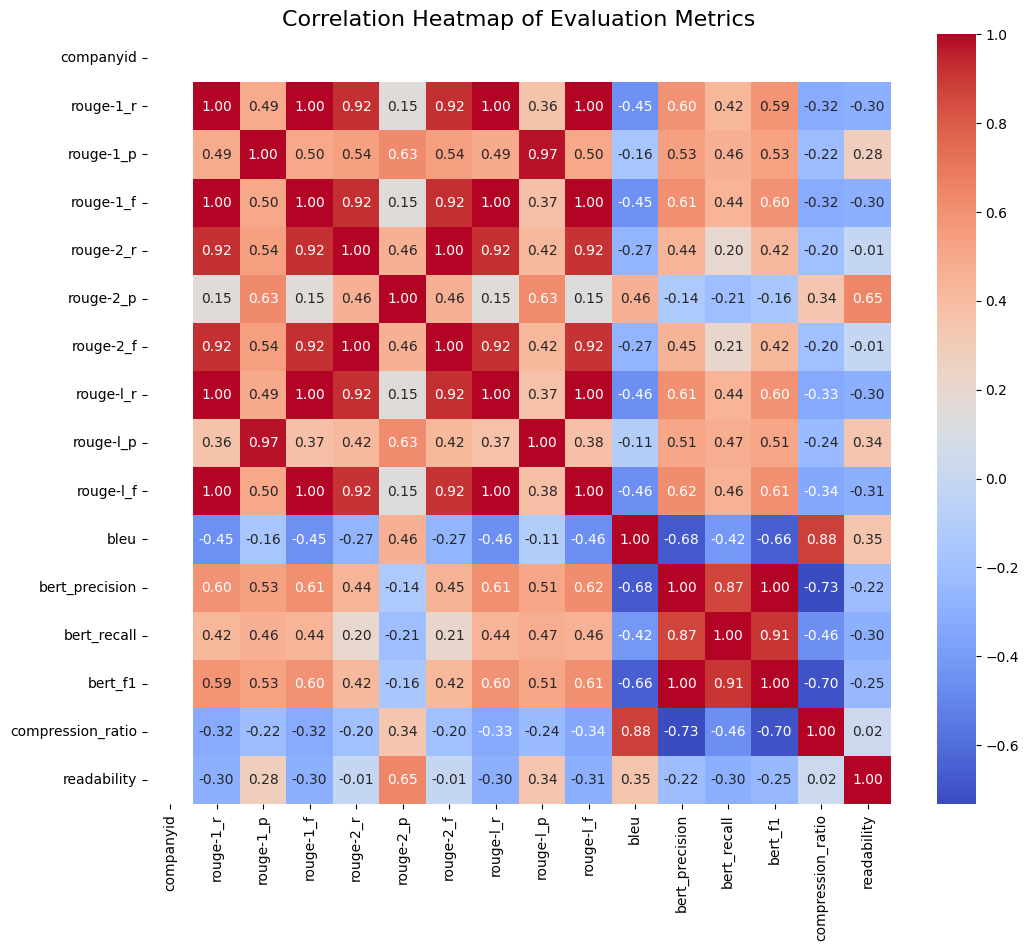

In [26]:
def visualize_results(df):
    """
    Visualizes evaluation metrics stored in a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing evaluation results with numeric metric columns.
    
    This function produces:
    - Histograms for each numeric metric.
    - A correlation heatmap of the numeric metrics.
    """
    # Select numeric columns (ignoring non-numeric columns such as model_name, uuid, etc.)
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    
    # Plot histograms for each numeric metric
    df[numeric_cols].hist(bins=20, figsize=(15, 10))
    plt.suptitle("Histograms of Evaluation Metrics", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # Plot a correlation heatmap of the numeric metrics
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap of Evaluation Metrics", fontsize=16)
    plt.show()

visualize_results(evaluation_results)